In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
from ivim_tensor import IvimTensorModel

In [3]:
from dipy.core.gradients import gradient_table

In [4]:
gtab = gradient_table('../data/DWI_IVIM6.bval', '../data/DWI_IVIM6.bvec', b0_threshold=0)

In [5]:
img = nib.load('../data/DWI_IVIM6.nii')

In [6]:
data = img.get_fdata()

In [7]:
b0 = np.mean(data[..., gtab.b0s_mask], -1)

In [8]:
from dipy.segment.mask import median_otsu
b0_mask, mask = median_otsu(b0, median_radius=2, numpass=1)

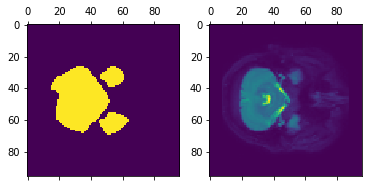

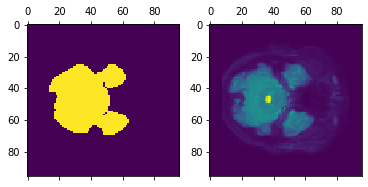

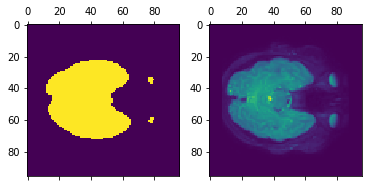

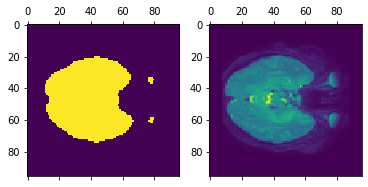

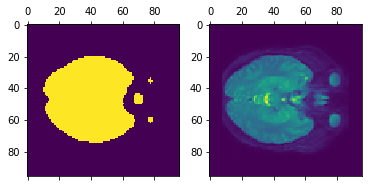

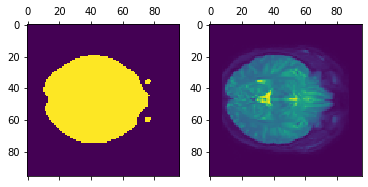

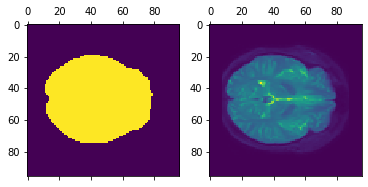

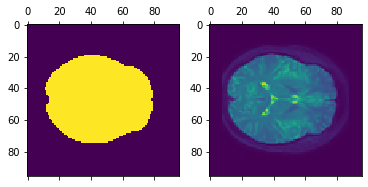

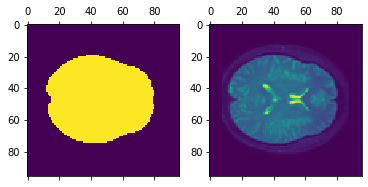

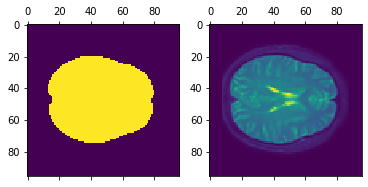

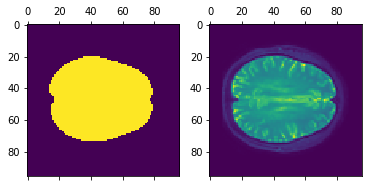

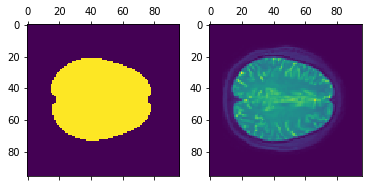

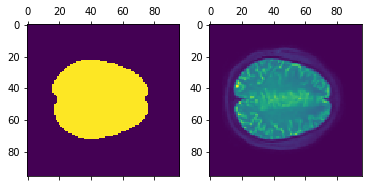

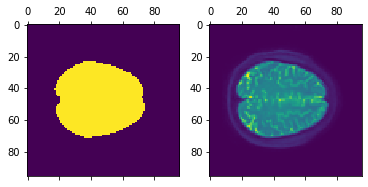

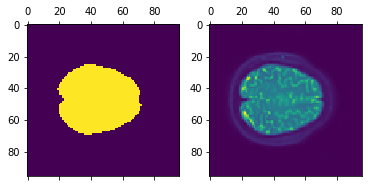

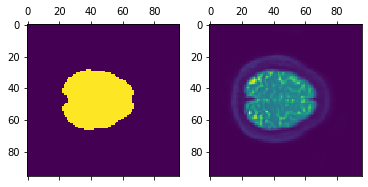

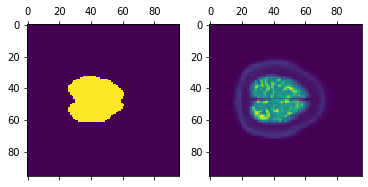

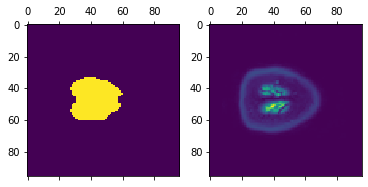

In [9]:
for sl in range(mask.shape[-1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].matshow(mask[:, :, sl])
    ax[1].matshow(data[:, :, sl, 0])

In [10]:
itm = IvimTensorModel(gtab, n_threads=1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/reconst/ivim.py:151: UserWarning: Bounds for this fit have been set from experiments and literature survey. To change the bounds, please input your bounds in model definition...
  warnings.warn(bounds_warning, UserWarning)


In [11]:
%%time
itf = itm.fit(data, mask)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/reconst/ivim.py:434: UserWarning: x0 obtained from linear fitting is not feasibile as initial guess for leastsq while estimating f and D_star. Using parameters from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/reconst/ivim.py:507: UserWarning: x0 is unfeasible for leastsq fitting. Returning x0 values from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dipy/reconst/ivim.py:344: UserWarning: Bounds are violated for leastsq fitting. Returning parameters from linear fit
  warnings.warn(warningMsg, UserWarning)


CPU times: user 1h 14min 54s, sys: 1.43 s, total: 1h 14min 55s
Wall time: 1h 14min 55s


In [12]:
debug

ERROR:root:No traceback has been produced, nothing to debug.


In [13]:
np.save('model_params', itf.model_params)

In [14]:
itf.model_params.shape

(38420, 13)

In [15]:
itf.perfusion_fraction.shape

(38420,)

(array([3536., 8210., 9840., 8535., 3877., 1541., 1113.,  663.,  442.,
         663.]),
 array([1.21155129e-13, 5.00000000e-02, 1.00000000e-01, 1.50000000e-01,
        2.00000000e-01, 2.50000000e-01, 3.00000000e-01, 3.50000000e-01,
        4.00000000e-01, 4.50000000e-01, 5.00000000e-01]),
 <BarContainer object of 10 artists>)

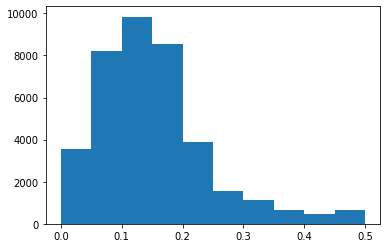

In [16]:
plt.hist(itf.perfusion_fraction)

In [17]:
pf = np.zeros(mask.shape)

In [18]:
pf[mask] = itf.perfusion_fraction

In [19]:
np.sum(np.isnan(itf.perfusion_fraction)) / len(itf.perfusion_fraction)

0.0

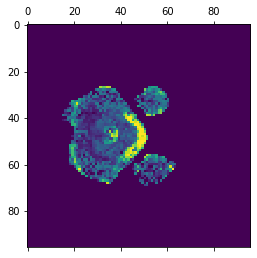

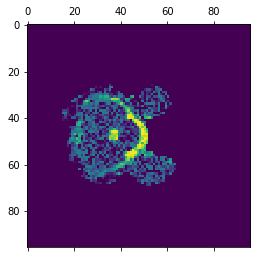

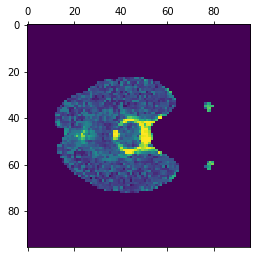

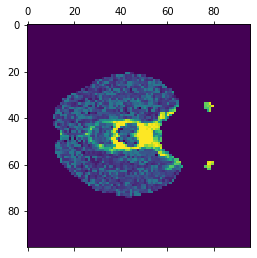

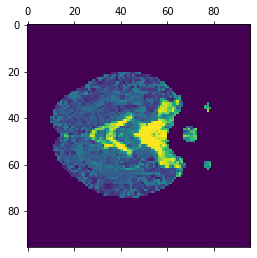

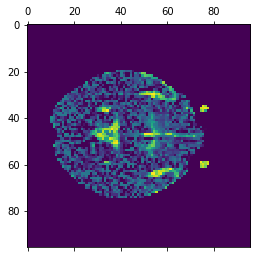

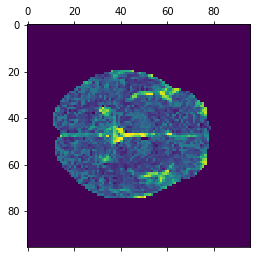

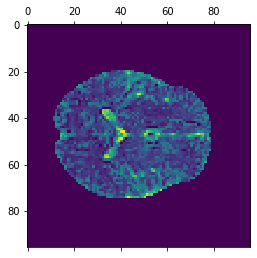

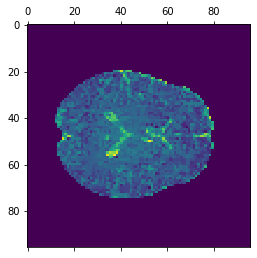

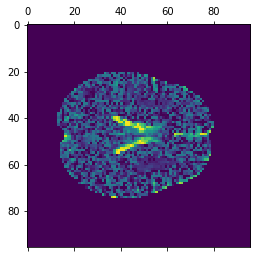

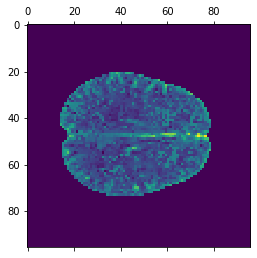

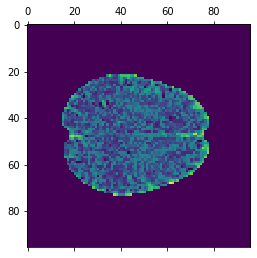

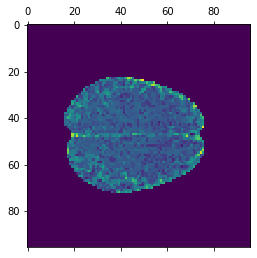

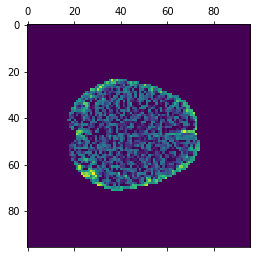

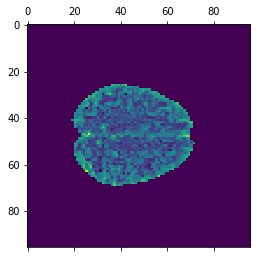

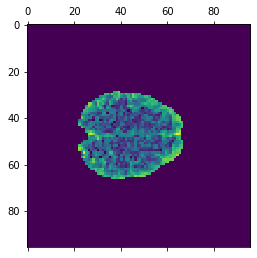

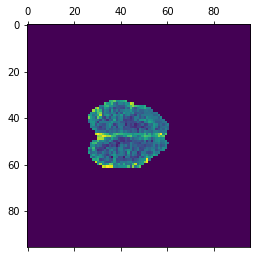

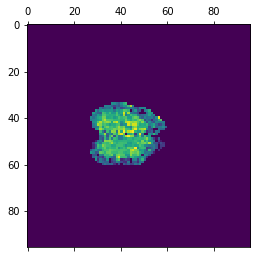

In [20]:
for sl in range(pf.shape[-1]):
    plt.matshow(pf[:, :, sl])

In [21]:
diffusion_cfa = np.zeros((mask.shape + (3,)))

In [22]:
diffusion_cfa[mask] = itf.diffusion_fit.color_fa

In [23]:
ivim_pf = np.zeros(mask.shape)

In [24]:
ivim_pf[mask] = itf.model.ivim_fit.perfusion_fraction

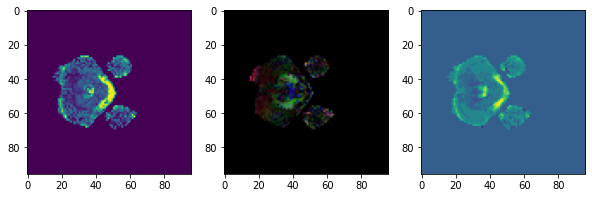

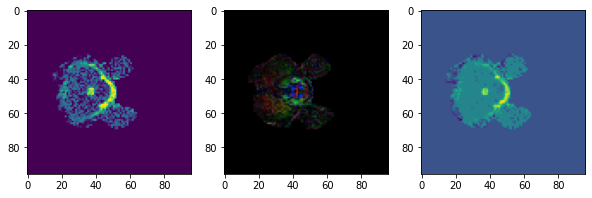

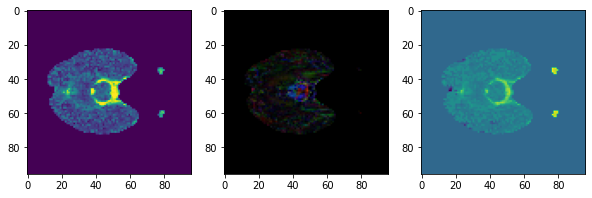

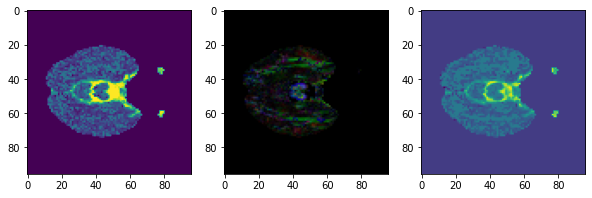

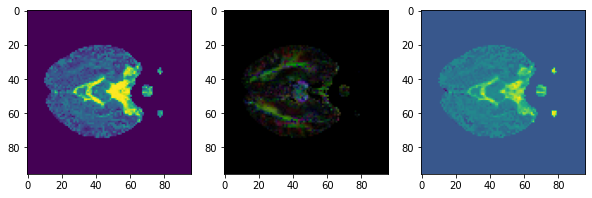

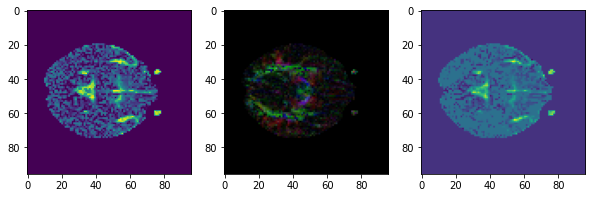

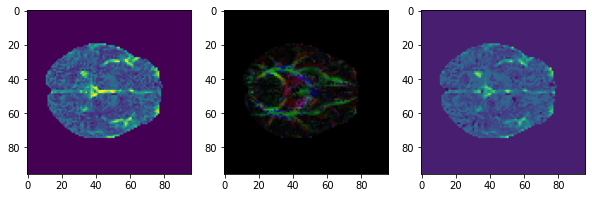

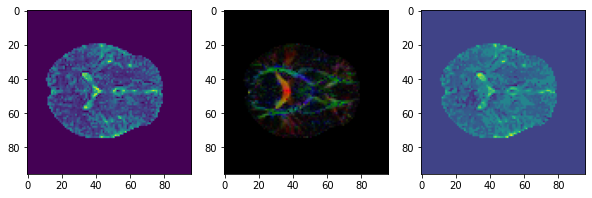

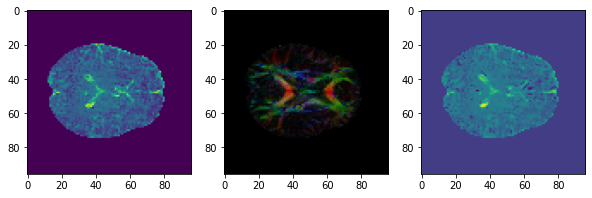

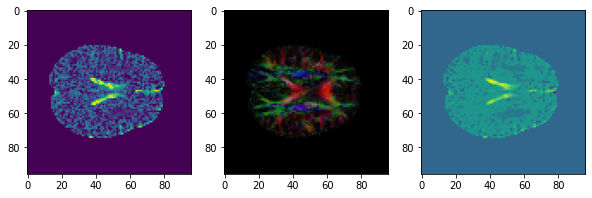

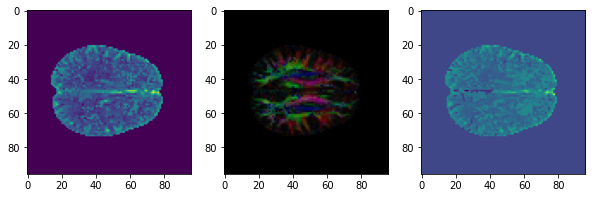

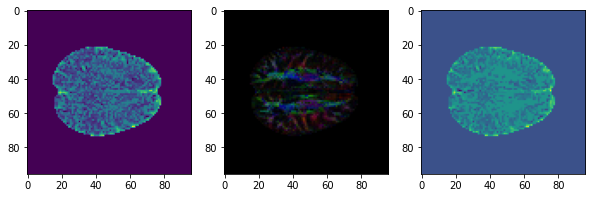

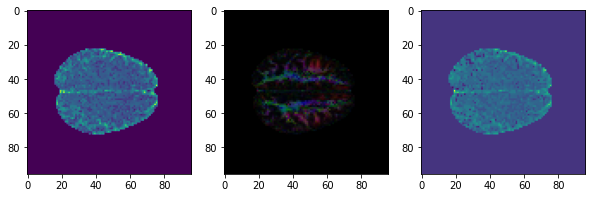

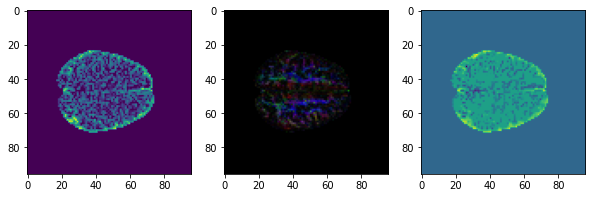

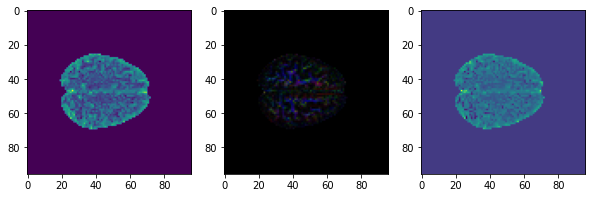

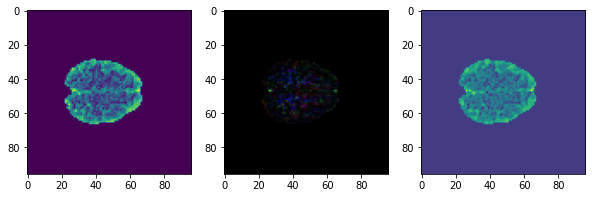

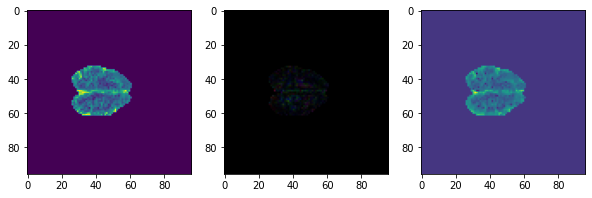

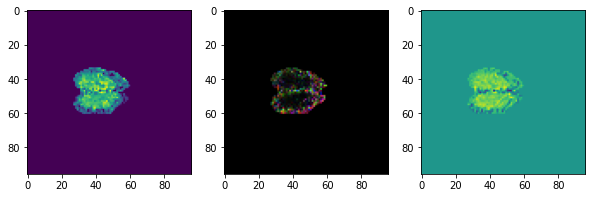

In [25]:
for sl in range(mask.shape[-1]):
    fig, ax = plt.subplots(1, 3, figsize=(10, 8))
    ax[0].imshow(pf[:, :, sl])
    ax[1].imshow(diffusion_cfa[:, :, sl])
    ax[2].imshow(ivim_pf[:, :, sl])

In [26]:
perfusion_cfa = np.zeros((mask.shape + (3,)))

In [27]:
perfusion_cfa[mask] = itf.perfusion_fit.color_fa

In [28]:
vec=np.array([1/np.sqrt(2), 1/np.sqrt(2), 0])

In [29]:
np.dot(vec * np.sqrt(0.5), vec * np.sqrt(0.5))

0.5

In [30]:
scaled_cfa = np.sqrt(perfusion_cfa * pf[..., None])

In [31]:
scfa_len = np.sqrt(np.sum(scaled_cfa * scaled_cfa, -1))

In [32]:
np.nanmax(np.abs(scfa_len - pf))

0.497918309238393

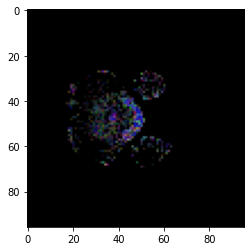

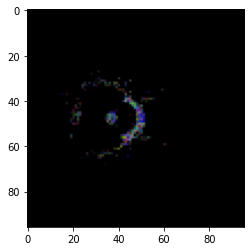

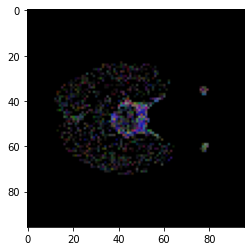

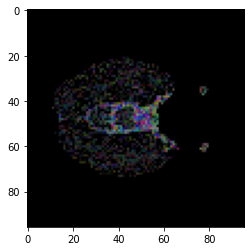

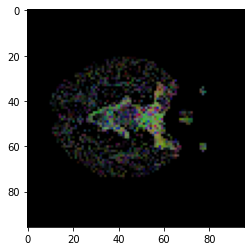

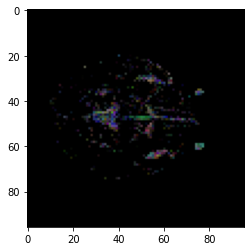

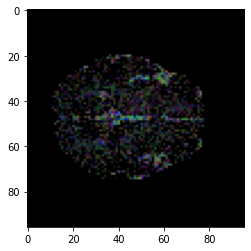

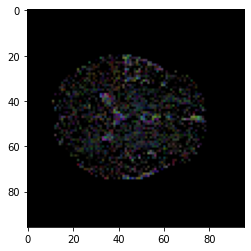

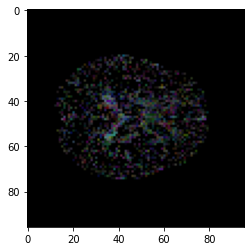

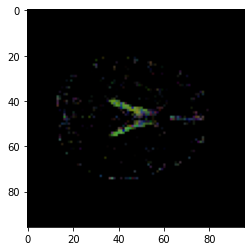

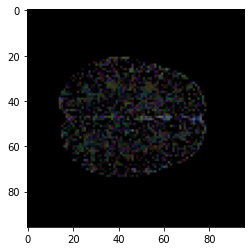

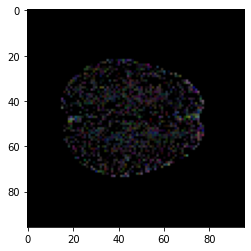

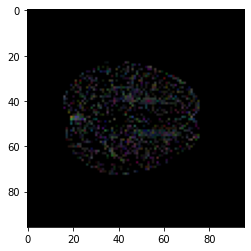

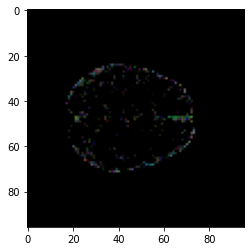

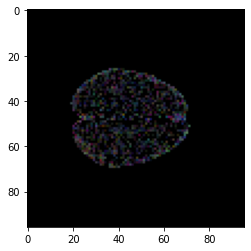

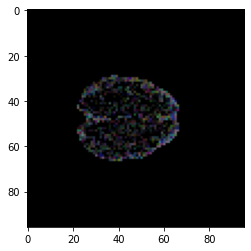

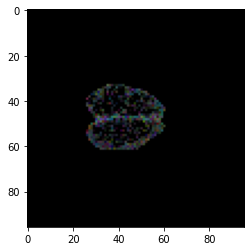

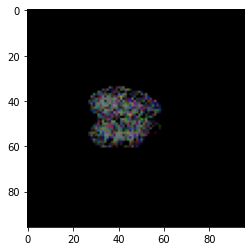

In [33]:
for sl in range(mask.shape[-1]):
    fig, ax = plt.subplots()
    ax.imshow(scaled_cfa[:, :, sl])

In [34]:
import nibabel as nib

In [35]:
nib.save(nib.Nifti1Image(pf, img.affine), 'perfusion_fraction.nii.gz')

In [36]:
dmd = np.zeros(mask.shape)

In [37]:
dmd[mask] = itf.diffusion_fit.md

In [38]:
nib.save(nib.Nifti1Image(dmd, img.affine), 'mean_diffusivity.nii.gz')

In [39]:
pmd = np.zeros(mask.shape)

In [40]:
pmd[mask] = itf.perfusion_fit.md
pmd[pf<0.001] = 0
pmd[pmd > 1] = 0

In [41]:
nib.save(nib.Nifti1Image(pmd, img.affine), 'mean_perfusivity.nii.gz')

In [42]:
np.where(pmd > 1)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [43]:
pred = itf.predict(gtab)

In [44]:
pred_vol = np.ones(data.shape)

pred_vol[mask] = pred

In [45]:
pred_vol.shape

(96, 96, 18, 79)

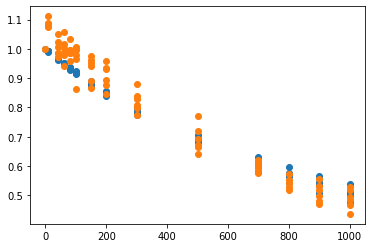

In [46]:
plt.plot(gtab.bvals, pred_vol[20, 43, 5], 'o')
plt.plot(gtab.bvals, data[20, 43, 5]/ data[20, 43, 5, -1], 'o')

In [47]:
pmd[20, 43, 5], pf[20, 43, 5]

(0.0030000000578601794, 0.14217932458840557)

In [48]:
nib.save(nib.Nifti1Image(ivim_pf, img.affine), 'ivim_perfusion_fraction.nii.gz')

In [49]:
pfa = np.zeros(mask.shape)
pfa[mask] = itf.perfusion_fit.fa

In [50]:
nib.save(nib.Nifti1Image(pfa, img.affine), 'perfusion_fa.nii.gz')

In [51]:
fa = np.zeros(mask.shape)
fa[mask] = itf.diffusion_fit.fa

In [52]:
nib.save(nib.Nifti1Image(fa, img.affine), 'diffusion_fa.nii.gz')